# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

### Consolidar Base de Dados

In [3]:
caminho_bases = pathlib.Path('dataset')
meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}
base = pd.DataFrame()




for arq in caminho_bases.iterdir():
    
    mes = meses[arq.name[:3]]
    ano = arq.name[-8:-4]
    
    df = pd.read_csv(caminho_bases / arq.name)
    df['Mes'] = mes
    df['Ano'] = ano
    base = pd.concat([base, df])
display(df)

C:\Users\Acer\AppData\Local\Temp\ipykernel_17880\847555478.py:13: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arq.name)
C:\Users\Acer\AppData\Local\Temp\ipykernel_17880\847555478.py:13: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arq.name)
C:\Users\Acer\AppData\Local\Temp\ipykernel_17880\847555478.py:13: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arq.name)
C:\Users\Acer\AppData\Local\Temp\ipykernel_17880\847555478.py:13: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arq.name)
C:\Users\Acer\AppData\Local\Temp\ipykernel_17880\847555478.py:13: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Mes,Ano
0,17878,https://www.airbnb.com/rooms/17878,20190923212307,2019-09-24,Very Nice 2Br - Copacabana - WiFi,Please note that special rates apply for Carni...,- large balcony which looks out on pedestrian ...,Please note that special rates apply for Carni...,none,This is the best spot in Rio. Everything happe...,...,strict_14_with_grace_period,f,f,1,1,0,0,2.13,9,2019
1,25026,https://www.airbnb.com/rooms/25026,20190923212307,2019-09-24,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",This newly renovated studio (last renovations ...,"Our apartment is a little gem, everyone loves ...",none,Copacabana is a lively neighborhood and the ap...,...,strict_14_with_grace_period,t,t,3,3,0,0,2.06,9,2019
2,31560,https://www.airbnb.com/rooms/31560,20190923212307,2019-09-24,NICE & COZY 1BDR - IPANEMA BEACH,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,This nice and clean 1 bedroom apartment is loc...,none,Die Nachbarschaft von Ipanema ist super lebend...,...,strict_14_with_grace_period,f,f,1,1,0,0,2.36,9,2019
3,35636,https://www.airbnb.com/rooms/35636,20190923212307,2019-09-24,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,"The location is extremely convenient, safe and...",This cosy apartment is just a few steps away ...,none,The apartment street is very quiet and safe ....,...,strict_14_with_grace_period,t,t,1,1,0,0,2.25,9,2019
4,35764,https://www.airbnb.com/rooms/35764,20190923212307,2019-09-24,COPACABANA SEA BREEZE - RIO - 20 X Superhost,Our newly renovated studio is located in the b...,"FEEL LIKE YOUR HOME LIVING AS ""CARIOCA"" LOCAL ...",Our newly renovated studio is located in the b...,none,Our guests will experience living with a local...,...,strict_14_with_grace_period,f,t,1,1,0,0,2.83,9,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,38844730,https://www.airbnb.com/rooms/38844730,20190923212307,2019-09-24,TRANSAMERICA BARRA DA TIJUCA R IV,"Em estilo contemporâneo, o Transamerica Prime ...",NaN,"Em estilo contemporâneo, o Transamerica Prime ...",none,NaN,...,flexible,f,f,15,15,0,0,NaN,9,2019
34325,38846408,https://www.airbnb.com/rooms/38846408,20190923212307,2019-09-24,Alugo para o Rock in Rio,"Confortável apartamento, 2 quartos , sendo 1 s...",O apartamento estará com mobília completa disp...,"Confortável apartamento, 2 quartos , sendo 1 s...",none,"Muito próximo ao Parque Olímpico, local do eve...",...,flexible,f,f,1,1,0,0,NaN,9,2019
34326,38846703,https://www.airbnb.com/rooms/38846703,20190923212307,2019-09-24,Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA,Apartamento quarto e sala COMPLETO para curtas...,Espaço ideal para até 5 pessoas. Cama de casal...,Apartamento quarto e sala COMPLETO para curtas...,none,NaN,...,strict_14_with_grace_period,f,f,29,23,6,0,NaN,9,2019
34327,38847050,https://www.airbnb.com/rooms/38847050,20190923212307,2019-09-24,Cobertura Cinematografica,Cobertura alto nivel,NaN,Cobertura alto nivel,none,NaN,...,strict_14_with_grace_period,f,f,1,1,0,0,NaN,9,2019


-Para evitar que nosso modelo fique lento, iremos retirar algumas colunas desnecessárias.

-Iremos criar um arquivo em excel com os 1000 primeiros registros para ajudar na vizualização e escolha das colunas.

-Os tipos de colunas que iremos remover:  
   1.  Id's, links e informações nao relevantes;
   2.  Colunas repetidas ou com mesma informação;
   3.  Colunas com texto livre;
   4.  Colunas com todos(ou quase) os valores iguais.




In [30]:
base.head(1000).to_csv('1000 Registros.csv', sep=';')


### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

In [4]:
print(base[['experiences_offered']].value_counts(), '\n')
print(base['host_acceptance_rate'].isnull().sum(),'\n')
print((base['host_listings_count'] == base['host_total_listings_count']).value_counts(),'\n')
print(base['square_feet'].isnull().sum(), '\n')


experiences_offered
none                   902210
Name: count, dtype: int64 

807468 

True     901750
False       460
Name: count, dtype: int64 

888162 



-Depois da análise qualitativa no Excel, ficaram as seguintes colunas:

In [5]:
#lista_colunas = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'Mes', 'Ano']
df_colunas = pd.read_csv("1000 Registros.csv", sep=';')
lista_colunas = list(df_colunas.columns)
print(lista_colunas)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'Mes', 'Ano']


-Modificando o DataFrame para apenas as colunas selecionadas permanecerem.


In [6]:
base = base.loc[:, lista_colunas]
display(base)

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,Mes,Ano
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,4,2018
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,4,2018
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,4,2018
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,4,2018
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,4,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,9,2019
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,9,2019
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,9,2019
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,9,2019


### Tratar Valores Faltando

In [13]:
#print(base.isnull().sum())


###Remover as colunas com mais de 300 mil dados nulos:###

for coluna in base:
    if base[coluna].isnull().sum() >= 300000:
        base = base.drop(coluna, axis=1)


###Remover as linhas com valores nulos###
        
base = base.dropna()
display(base)


,Unnamed: 0,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,instant_bookable,is_business_travel_ready,cancellation_policy,Mes,Ano
0,0,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,0.0,...,2,34.0,60,365,38,f,f,strict_14_with_grace_period,4,2018
1,1,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,2.0,...,2,51.0,4,90,205,t,f,strict,4,2018
2,2,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,1.0,...,2,215.0,3,90,85,f,f,strict,4,2018
3,3,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,1.0,...,2,45.0,4,30,208,f,f,strict,4,2018
4,4,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,1.0,...,2,68.0,2,1125,200,t,f,strict,4,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810421,34323,f,1.0,-22.986030,-43.191660,Apartment,Entire home/apt,4,2.0,2.0,...,1,0.0,1,1125,0,f,f,flexible,9,2019
810422,34324,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,0.0,...,2,50.0,1,1125,0,f,f,flexible,9,2019
810424,34326,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,1.0,...,3,30.0,3,1125,0,f,f,strict_14_with_grace_period,9,2019
810425,34327,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,1.0,...,1,0.0,1,1125,0,f,f,strict_14_with_grace_period,9,2019


### Verificar Tipos de Dados em cada coluna

In [57]:
print(base.dtypes, '\n\n')
display(base.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
Mes                           int64
Ano                           int32
dtype: object 




host_is_superhost                                                           f
host_listings_count                                                       1.0
latitude                                                           -22.946854
longitude                                                          -43.182737
property_type                                                       Apartment
room_type                                                     Entire home/apt
accommodates                                                                4
bathrooms                                                                 1.0
bedrooms                                                                  0.0
beds                                                                      2.0
bed_type                                                             Real Bed
amenities                   {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                                           

-As colunas de preço e pessoas extra estão sendo tratadas como textos, precisamos converte-las para float.
-A coluna de ano está sendo tratada como texto, mudaremos para int.

In [36]:
base['price'] = base['price'].str.replace('$', '')
base['price'] = base['price'].str.replace(',', '')
base['price'] = base['price'].astype(np.float32, copy=False)

base['extra_people'] = base['extra_people'].str.replace('$', '')
base['extra_people'] = base['extra_people'].str.replace(',', '')
base['extra_people'] = base['extra_people'].astype(np.float32, copy=False)

base['Ano'] = base['Ano'].astype(np.int32, copy=False)

### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5x Amplitude e valores acima de Q3 + 1.5x Amplitude). (Amplitude = Q3 - Q1)
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

NÃO saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo.

<Axes: >

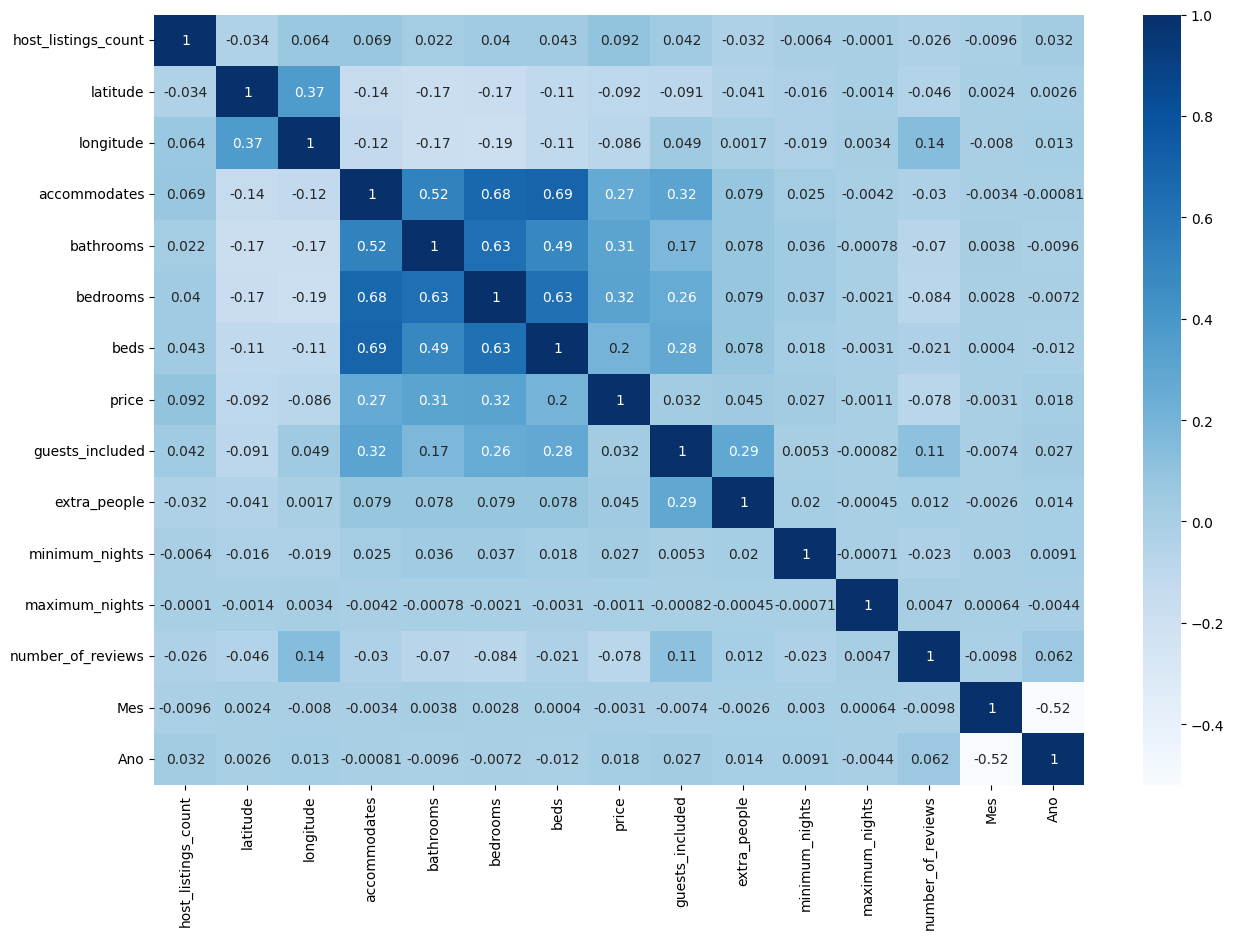

In [37]:
plt.figure(figsize=(15, 10))
sns.heatmap(base.corr(numeric_only=True), annot=True, cmap='Blues')

### Definiçao de funções para a análise

In [4]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    ampltitude = q3 - q1

    return q1 - 1.5 * ampltitude, q3 + 1.5 * ampltitude

def diagramas(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15,5)
    
    sns.boxplot(x=coluna, ax = ax1)
    
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax = ax2)

def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(data=base, x=coluna, element='bars')    

def excluir_outliers(df, nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]

    return df, qtd_linhas - df.shape[0]

def grafico_barras(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index, y =coluna.value_counts())
    ax.set_xlim(limites(coluna))



Iremos remover os outliers.

#### Price

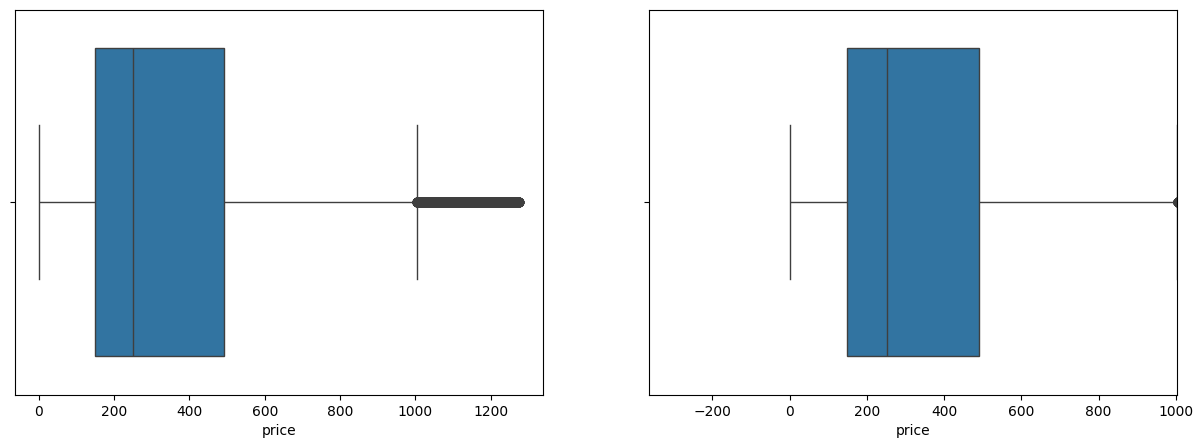

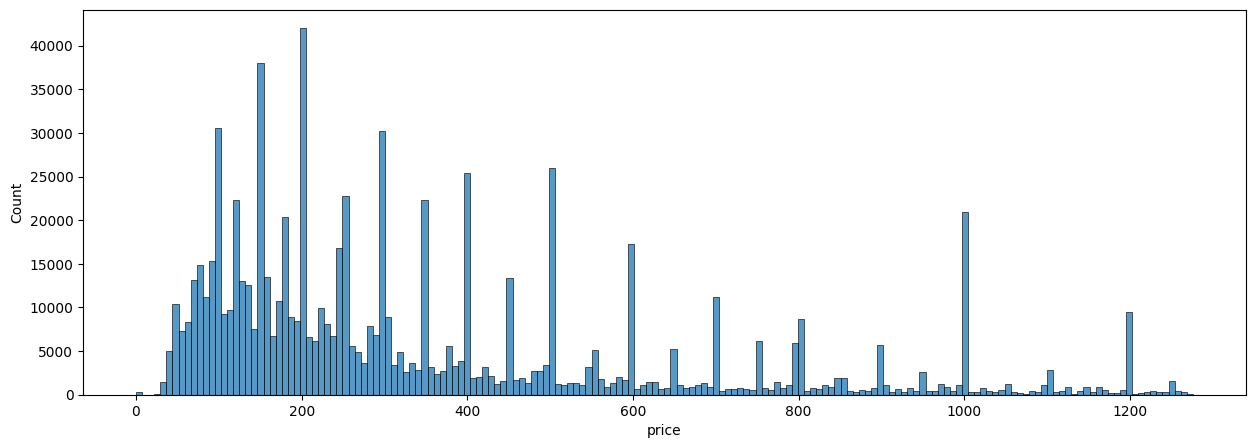

In [22]:
diagramas(base['price'])
histograma(base['price'])

In [37]:
base, linhas_removidas = excluir_outliers(base, 'price')
print(linhas_removidas)

28567


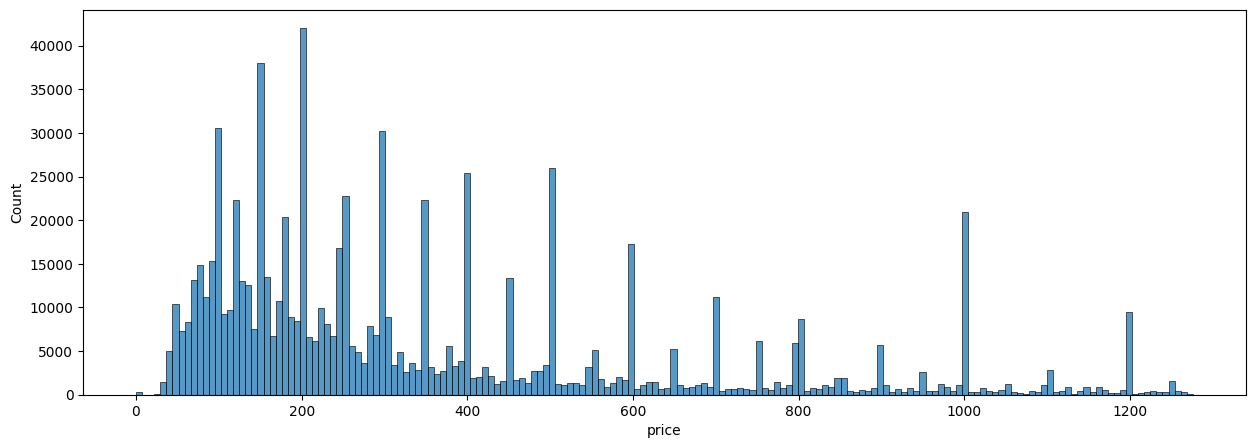

In [91]:
histograma(base['price'])

#### Extra People


59194


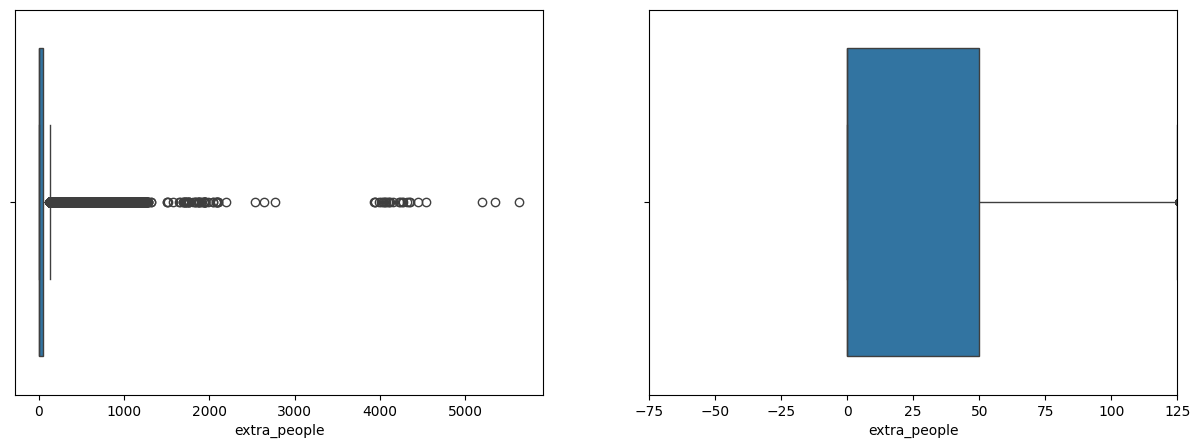

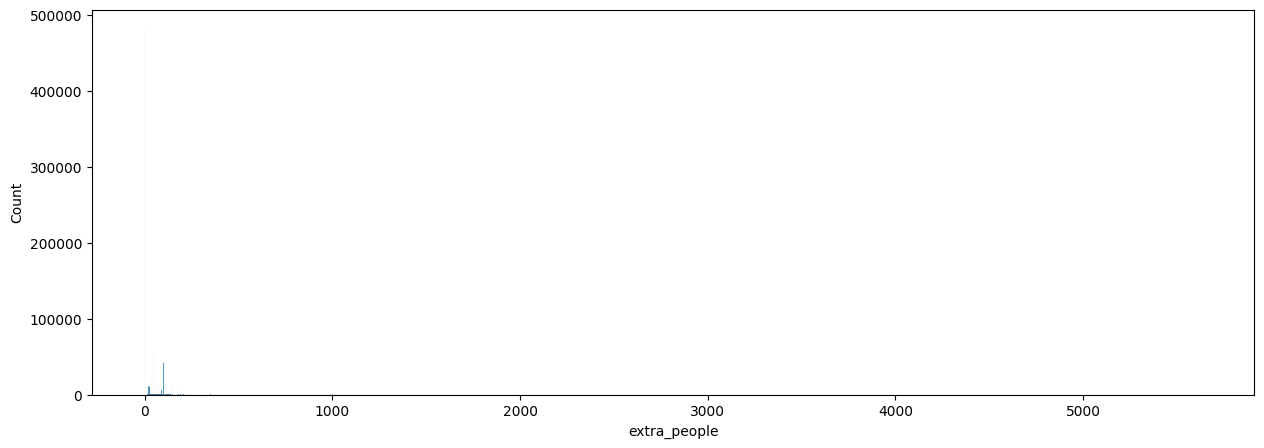

In [39]:
diagramas(base['extra_people'])
histograma(base['extra_people'])
base, linhas_removidas = excluir_outliers(base, 'extra_people')
print(linhas_removidas)


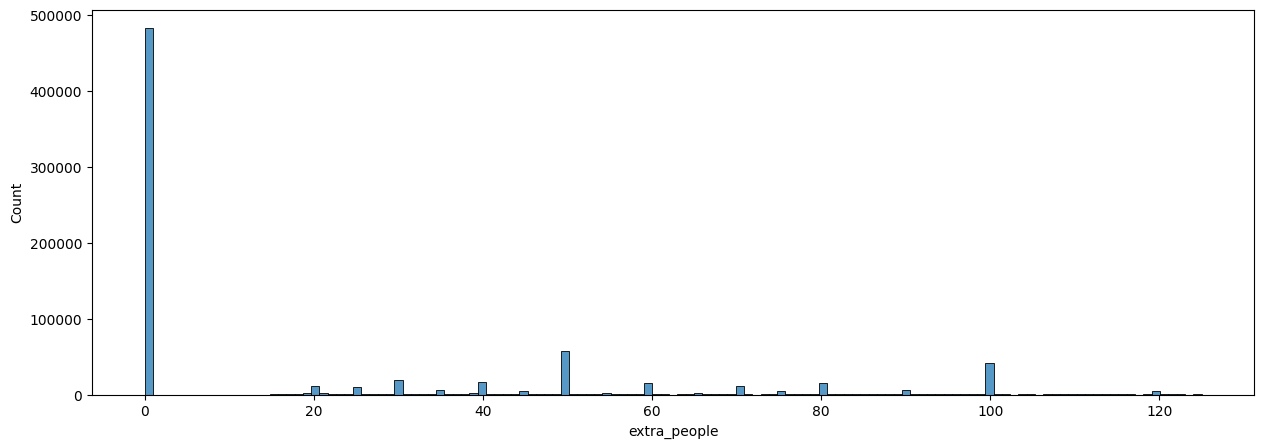

In [40]:
histograma(base['extra_people'])

#### Host listings count
Iremos remover os outliers pois supomos que Hosts com mais de 6 imóveis sejam imobiliárias ou profissionais da área, e esse não é nosso público alvo.

97723


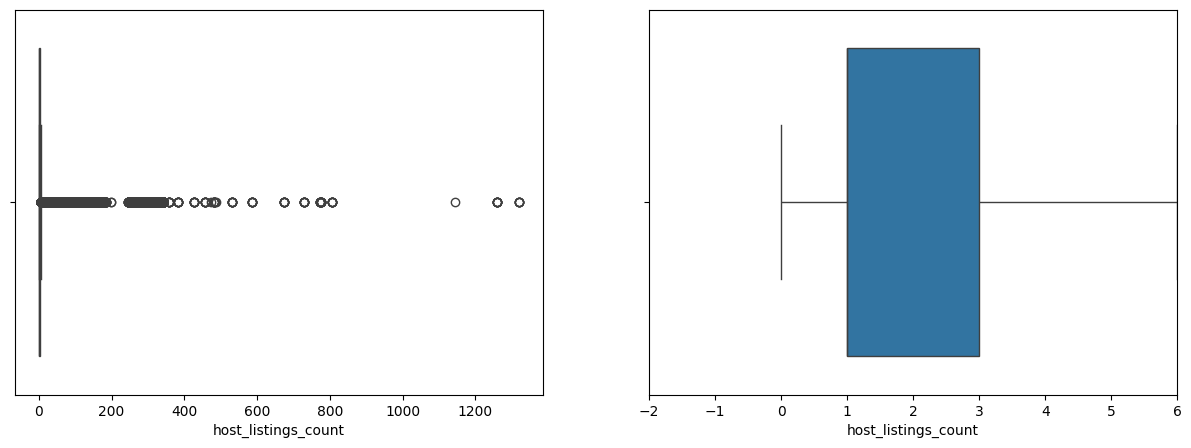

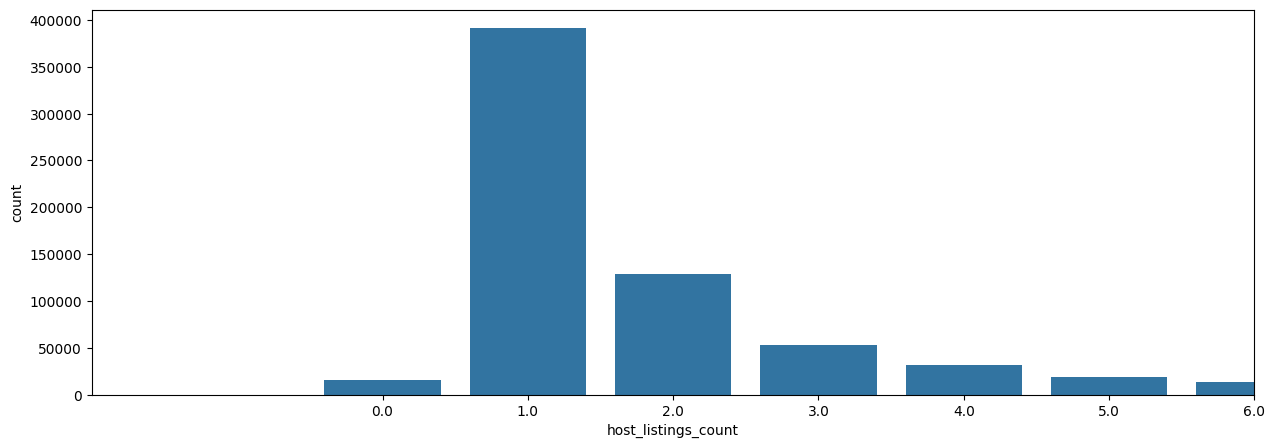

In [41]:
diagramas(base['host_listings_count'])
grafico_barras(base['host_listings_count'])
base, linhas_removidas = excluir_outliers(base, 'host_listings_count')
print(linhas_removidas)

#### Accommodates

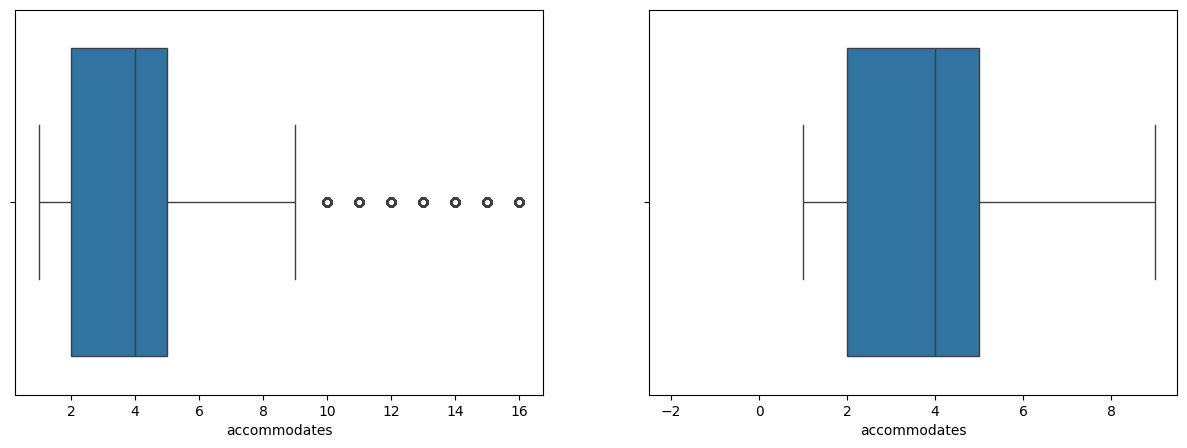

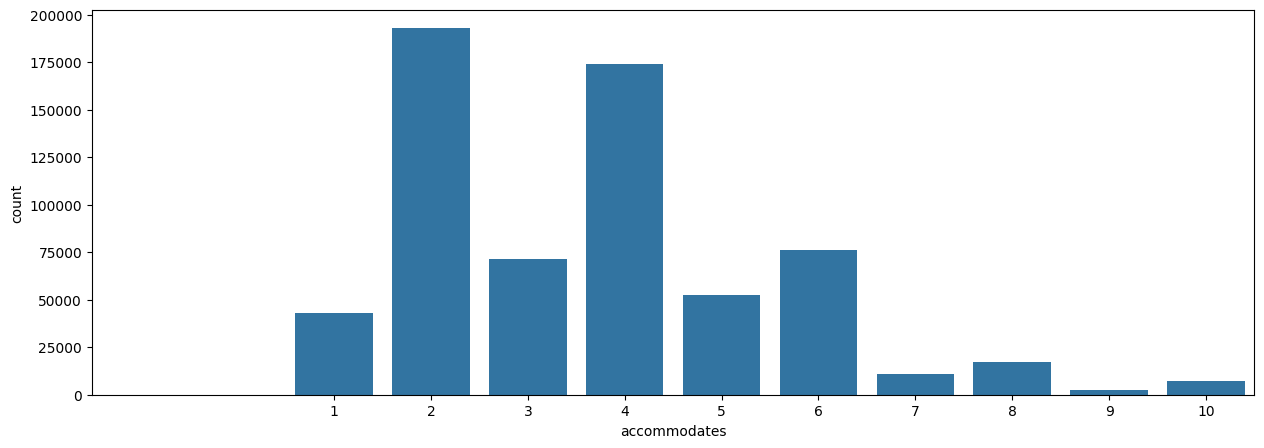

In [43]:
diagramas(base['accommodates'])
grafico_barras(base['accommodates'])

In [45]:
base, linhas_removidas = excluir_outliers(base, 'accommodates')
print(linhas_removidas)

13146


#### Bathrooms

<Axes: xlabel='bathrooms', ylabel='count'>

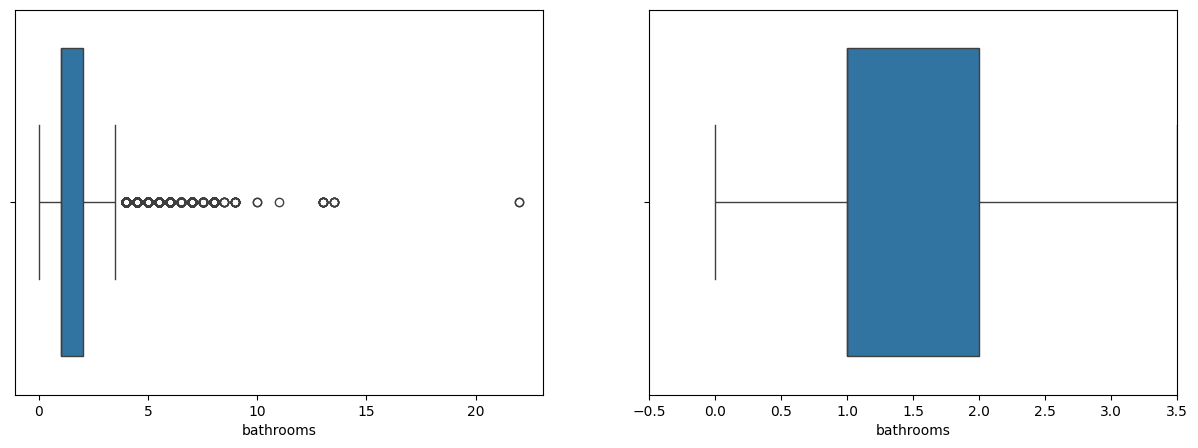

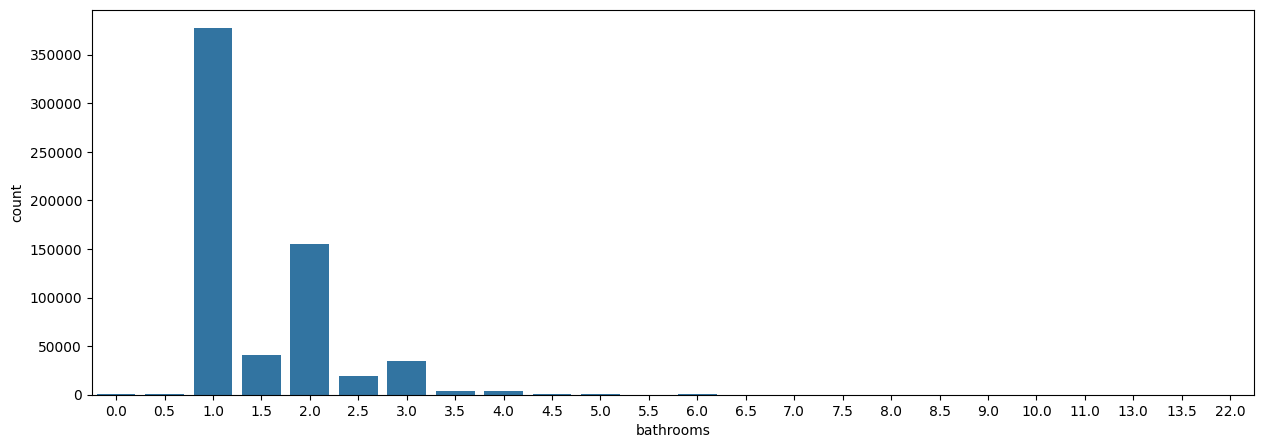

In [47]:
diagramas(base['bathrooms'])
plt.figure(figsize=(15,5))
sns.barplot(x=base['bathrooms'].value_counts().index, y =base['bathrooms'].value_counts())

In [48]:
base, linhas_removidas = excluir_outliers(base, 'bathrooms')
print(linhas_removidas)

6894


#### Bedrooms

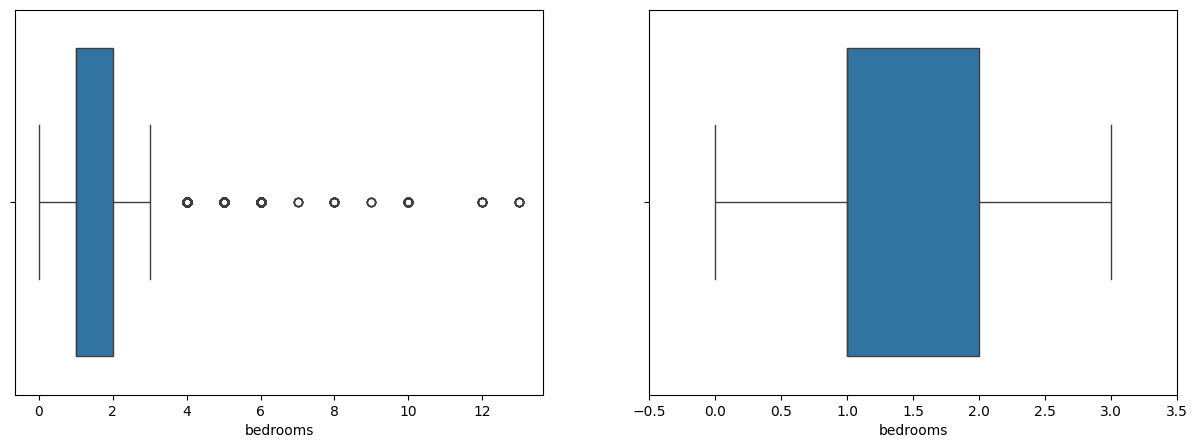

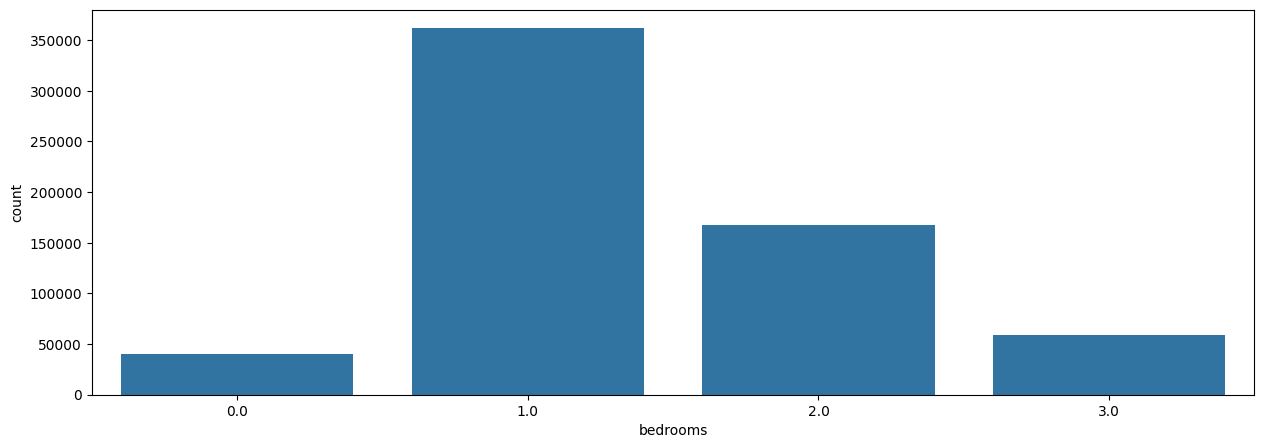

In [49]:
diagramas(base['bedrooms'])
grafico_barras(base['bedrooms'])


In [50]:
base, linhas_removidas = excluir_outliers(base, 'bedrooms')
print(linhas_removidas)

5482


#### Beds

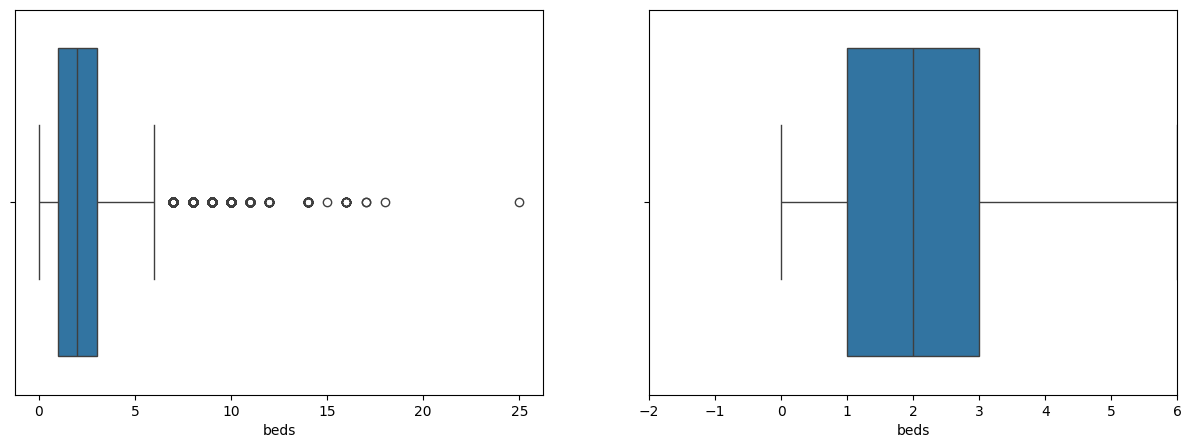

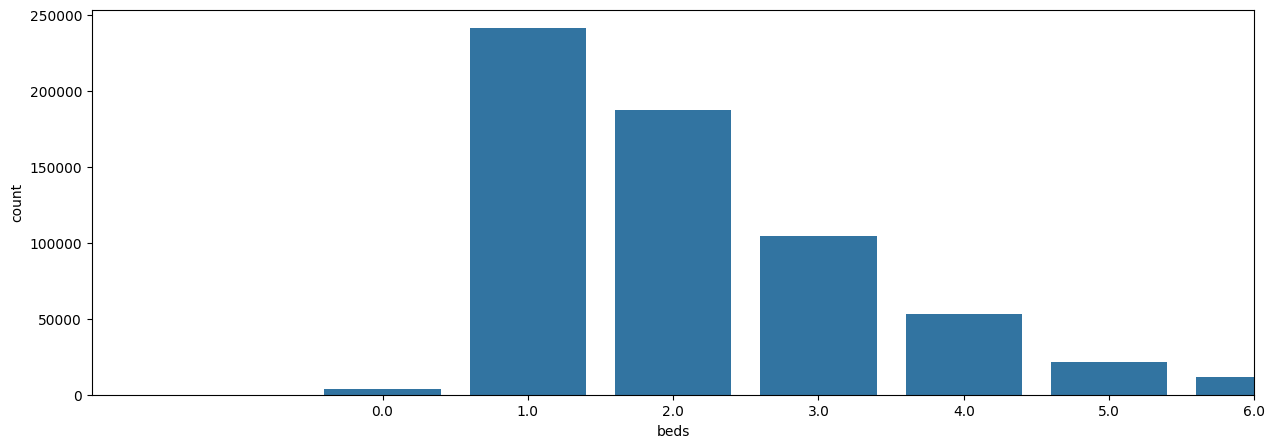

In [51]:
diagramas(base['beds'])
grafico_barras(base['beds'])

In [52]:
base, linhas_removidas = excluir_outliers(base, 'beds')
print(linhas_removidas)

5622


#### Guests included

C:\Users\Acer\AppData\Local\Temp\ipykernel_4516\2565206981.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))


<Axes: xlabel='guests_included', ylabel='count'>

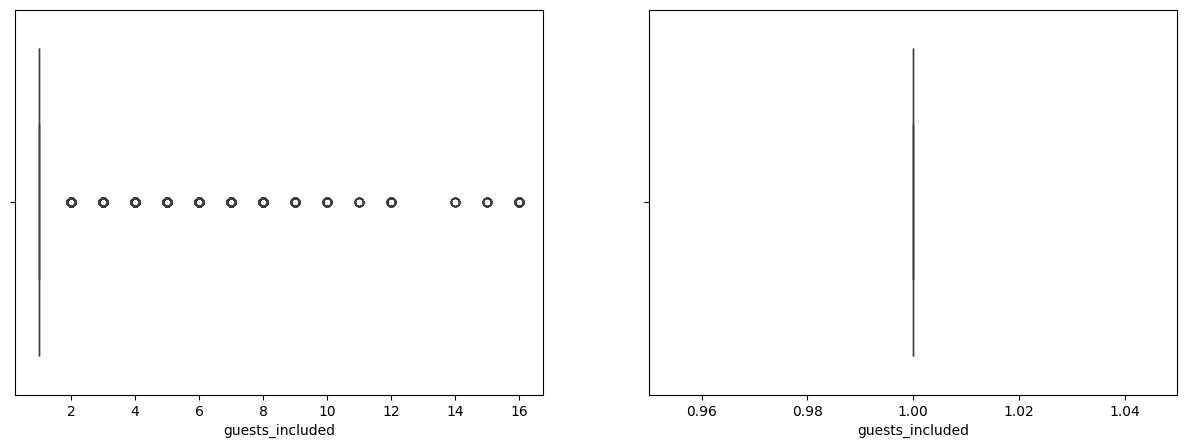

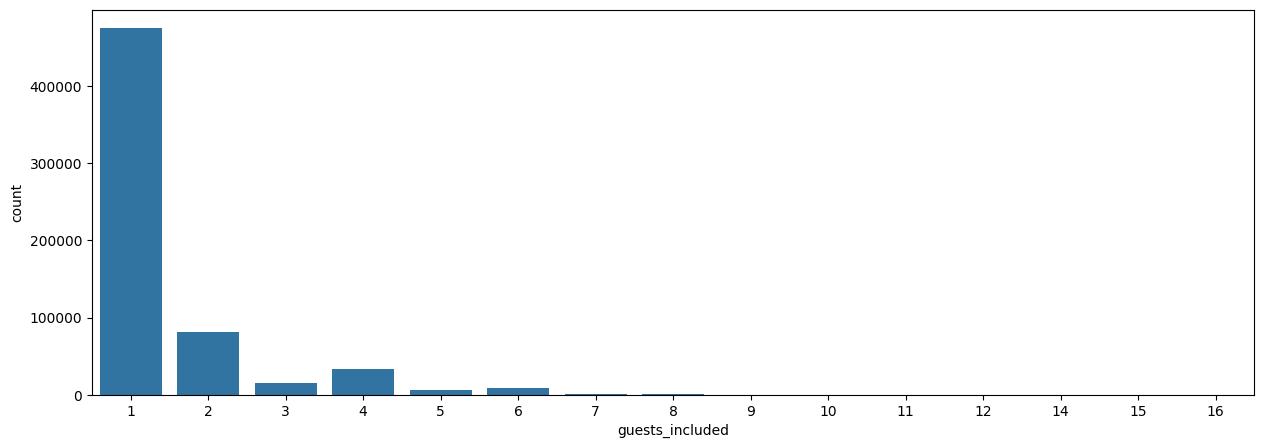

In [55]:
diagramas(base['guests_included'])
plt.figure(figsize=(15,5))
sns.barplot(x=base['guests_included'].value_counts().index, y =base['guests_included'].value_counts())

Após uma análise, concluí que seria melhor remover a feature de guests included, pois aparenta que grande parte dos usuários não altera o valor padrão, 1, então pode acabar gerando uma imprecisão em nossa análise.

In [61]:
base = base.drop('guests_included', axis=1)
base.shape

(622366, 22)

#### Minimum nights

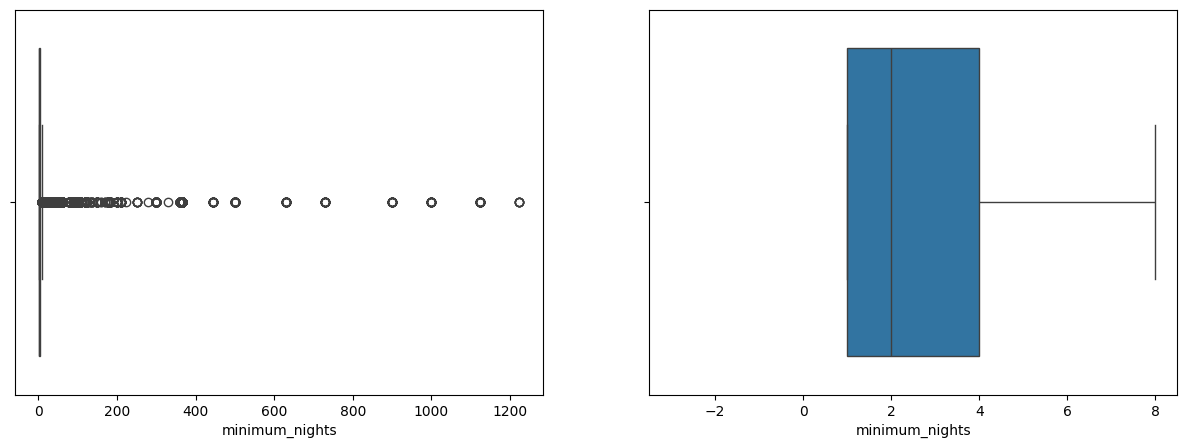

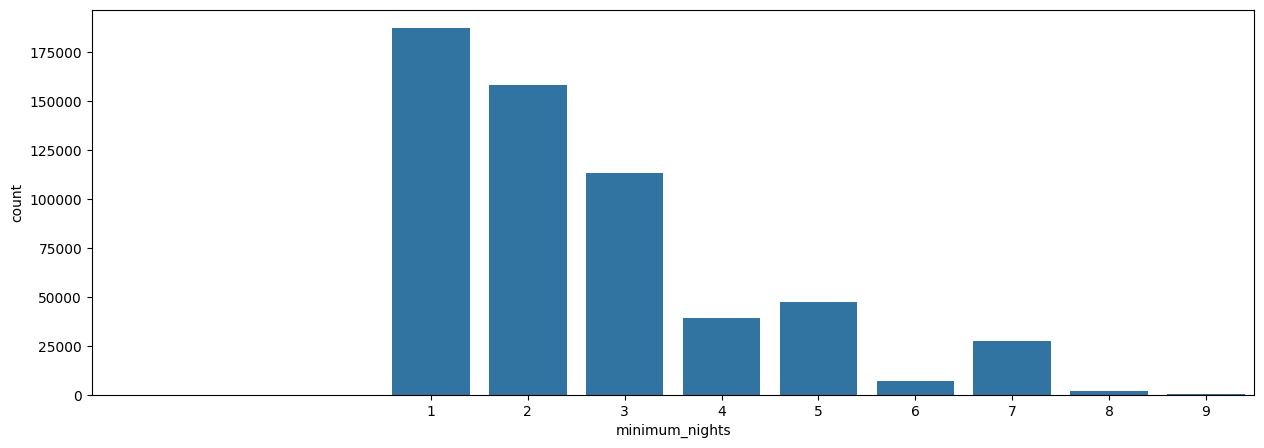

In [63]:
diagramas(base['minimum_nights'])
grafico_barras(base['minimum_nights'])

In [65]:
base, linhas_removidas = excluir_outliers(base, 'minimum_nights')
print(linhas_removidas)

40383


#### Maximum nights
Após análise, aparenta ser uma feature que nao vai influenciar no nosos modelo, portanto, iremos remover.

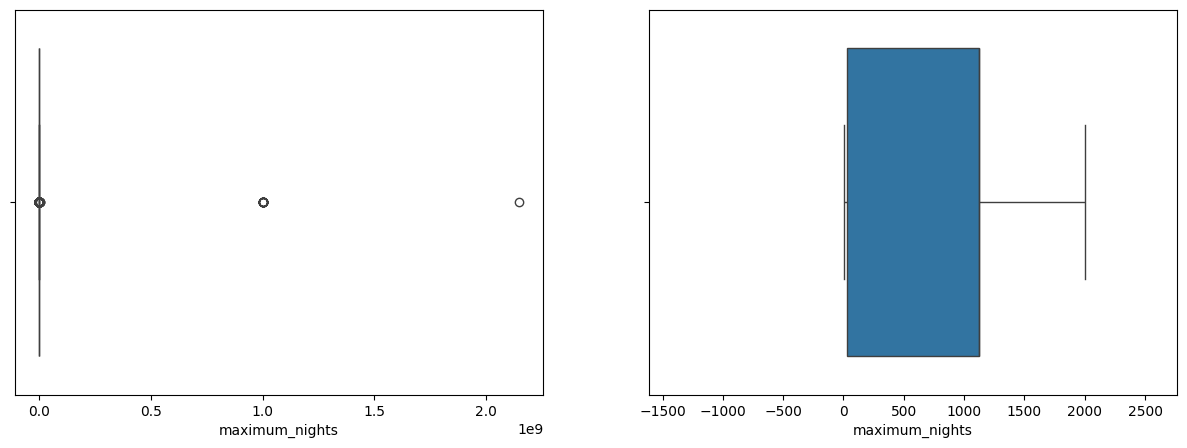

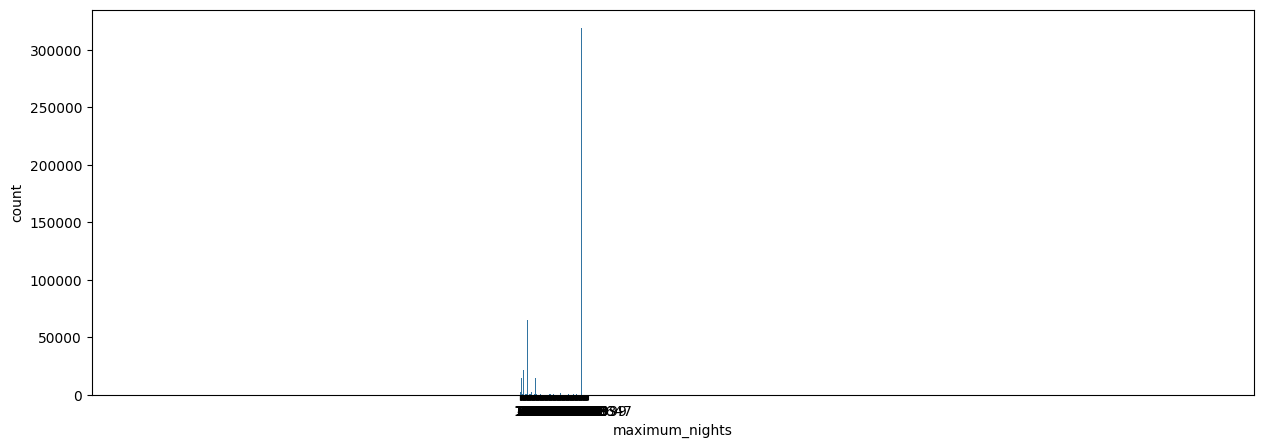

In [66]:
diagramas(base['maximum_nights'])
grafico_barras(base['maximum_nights'])

In [67]:
base = base.drop('maximum_nights', axis=1)
base.shape

(581983, 21)

#### Number of reviews
Após análise, concluí que removendo os outliers dessa feature, iria acabar por remover imóveis/hosts consolidados na plataforma, oq não faria sentido, pois nosso modelo busca ajudar pessoas que estão entrando nesse mercado, então, nao terão reviews. Além de que, como apresentado anteriormente, preço e número de reviews apresentam uma correlação baixíssima, portanto iremos remover essa coluna.

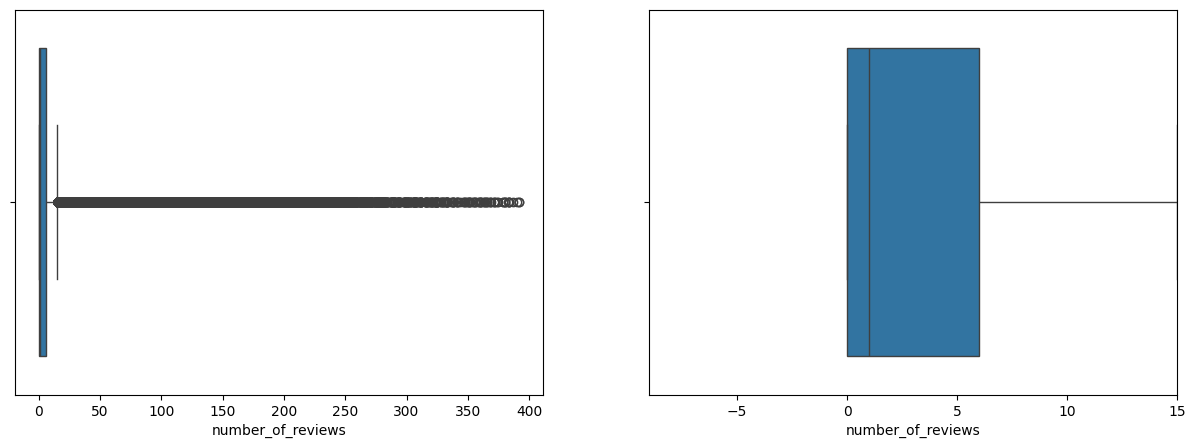

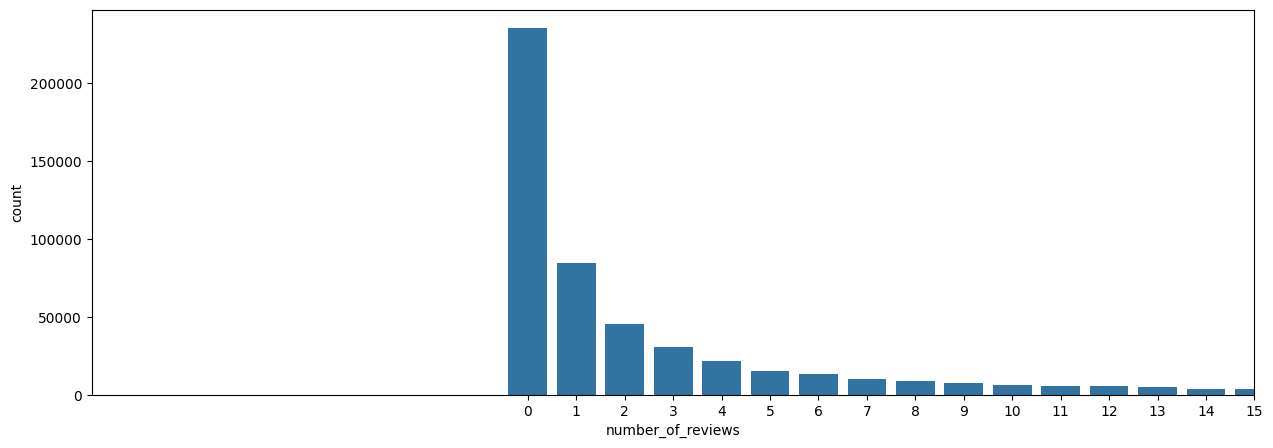

In [68]:
diagramas(base['number_of_reviews'])
grafico_barras(base['number_of_reviews'])

In [69]:
base = base.drop('number_of_reviews', axis=1)
base.shape

(581983, 20)

### Tratamento de colunas de texto

property_type               
room_type                    
bed_type                     
amenities                   
cancellation_policy         



##### Property type

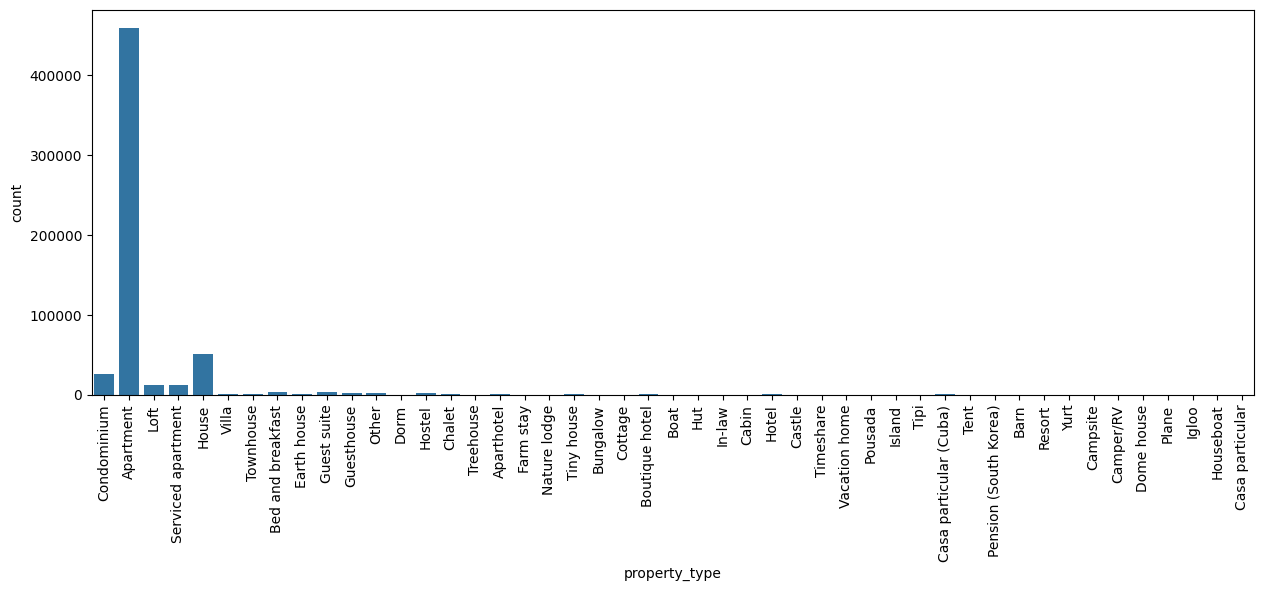

In [76]:

plt.figure(figsize=(15,5))
graph = sns.countplot(x='property_type', data = base)
graph.tick_params(axis='x', rotation=90)

Agrupando tipos com menos de 2000 listagens:

In [81]:
tipos_imoveis = base['property_type'].value_counts()
linhas_agrupamento = []

for tipo in tipos_imoveis.index:
    if tipos_imoveis[tipo] < 2000:
        linhas_agrupamento.append(tipo)

for tipo in linhas_agrupamento:
    base.loc[base['property_type'] == tipo, 'property_type'] = 'Other'

[]


#### Room type

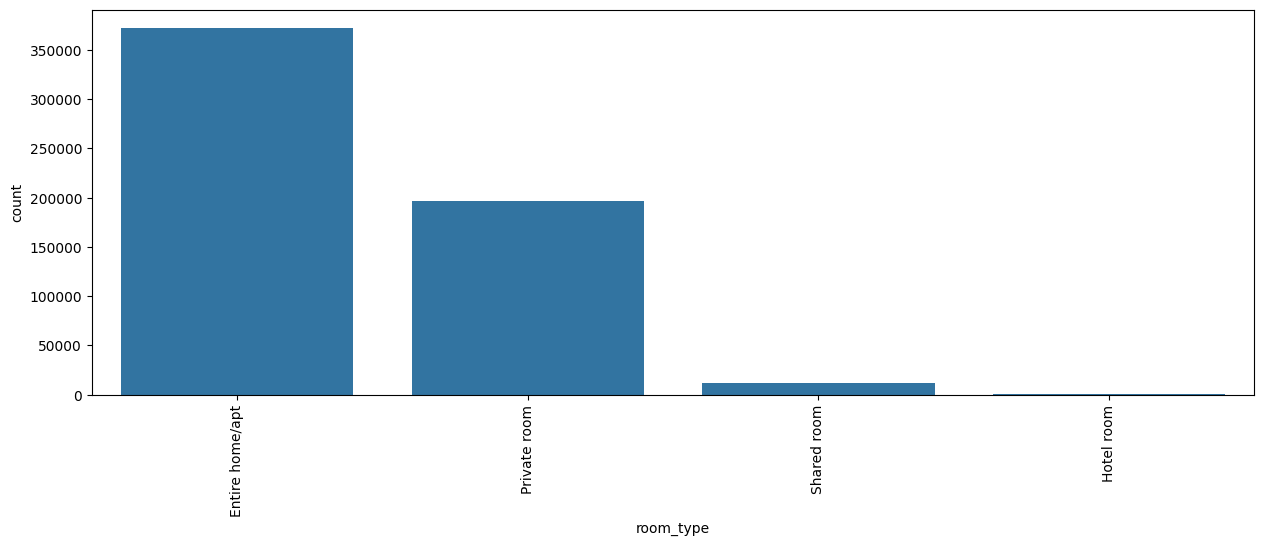

In [84]:
plt.figure(figsize=(15,5))
graph = sns.countplot(x='room_type', data = base)
graph.tick_params(axis='x', rotation=90)

#### Bed type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64


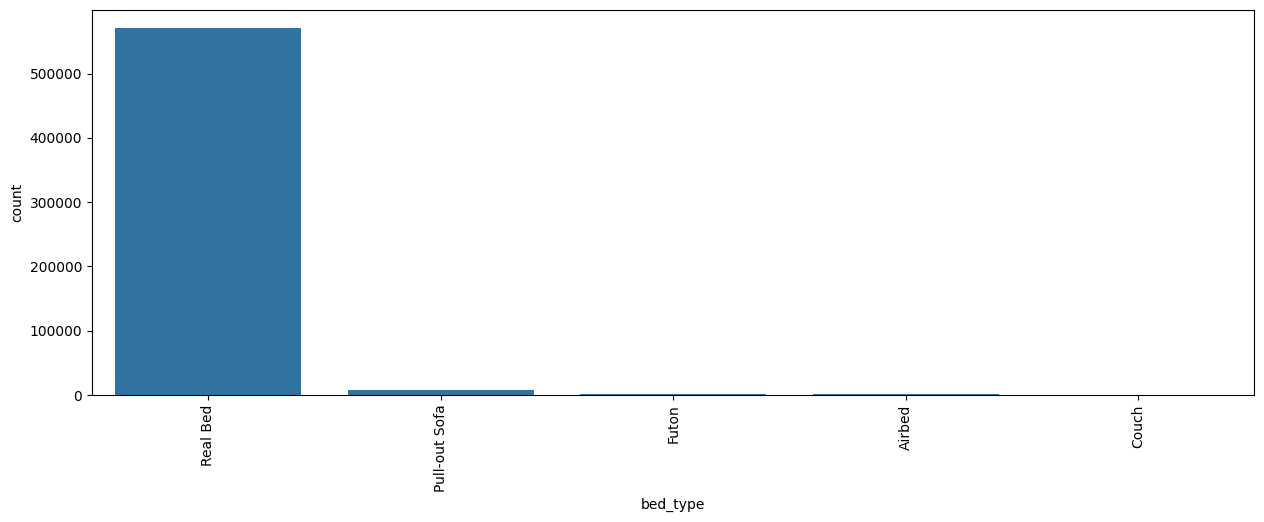

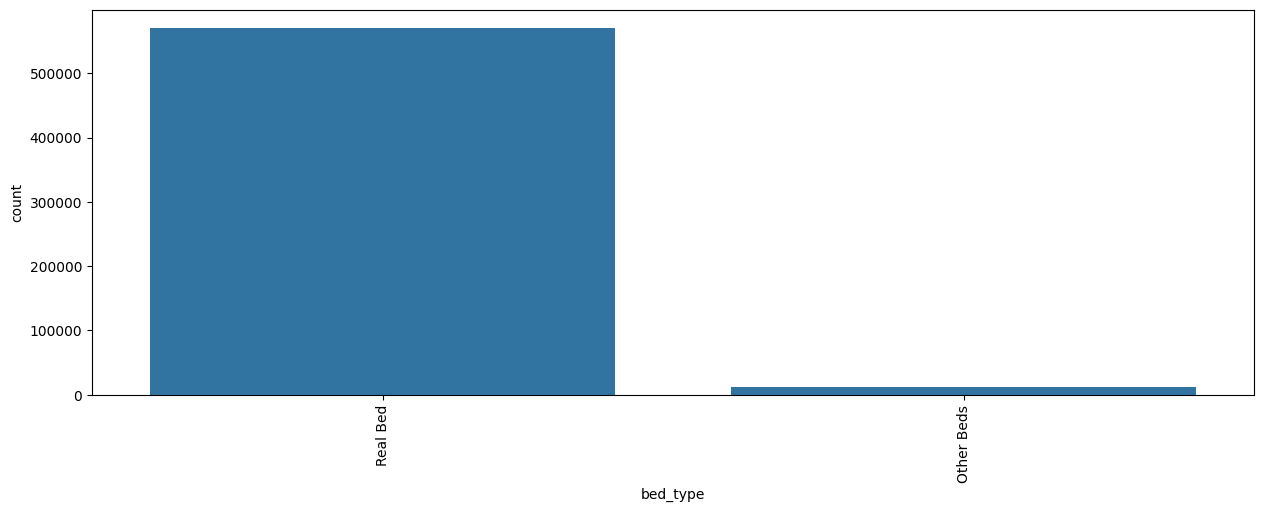

In [89]:
print(base['bed_type'].value_counts())
plt.figure(figsize=(15,5))
graph = sns.countplot(x='bed_type', data = base)
graph.tick_params(axis='x', rotation=90)

tipos_bed = base['bed_type'].value_counts()
linhas_bed = []

for tipo in tipos_bed.index:
    if tipos_bed[tipo] < 10000:
        linhas_bed.append(tipo)

for tipo in linhas_bed:
    base.loc[base['bed_type'] == tipo, 'bed_type'] = 'Other Beds'

plt.figure(figsize=(15,5))
graph = sns.countplot(x='bed_type', data = base)
graph.tick_params(axis='x', rotation=90)

#### Cancellation policy

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64


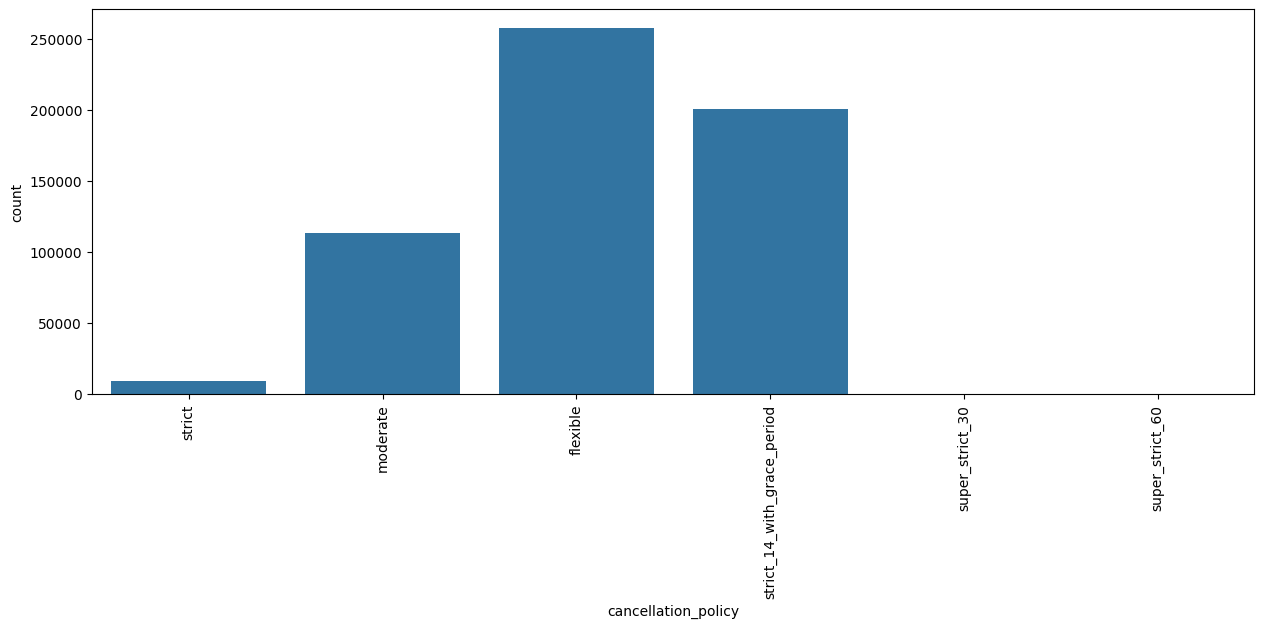

In [86]:
print(base['cancellation_policy'].value_counts())
plt.figure(figsize=(15,5))
graph = sns.countplot(x='cancellation_policy', data = base)
graph.tick_params(axis='x', rotation=90)

In [87]:
tipos_cancellation = base['cancellation_policy'].value_counts()
linhas_cancellation = []

for tipo in tipos_cancellation.index:
    if tipos_cancellation[tipo] < 10000:
        linhas_cancellation.append(tipo)

for tipo in linhas_cancellation:
    base.loc[base['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

#### Amenities
-Por conta dos amenities apresentarem uma variedade muito grande e certa inconsistência, iremos transformá-los em número de amenities, aumentando a precisão.

In [92]:
print(base['amenities'].iloc[0])
base['total_amenities'] = base['amenities'].str.split(',').apply(len)
base = base.drop('amenities', axis=1)
base.shape

{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Paid parking off premises","Smoking allowed",Doorman,Elevator,"Hot tub","Family/kid friendly","Suitable for events",Essentials,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in","Front desk/doorperson","Private entrance","Hot water","Bed linens","Luggage dropoff allowed"}


(581983, 20)

24343


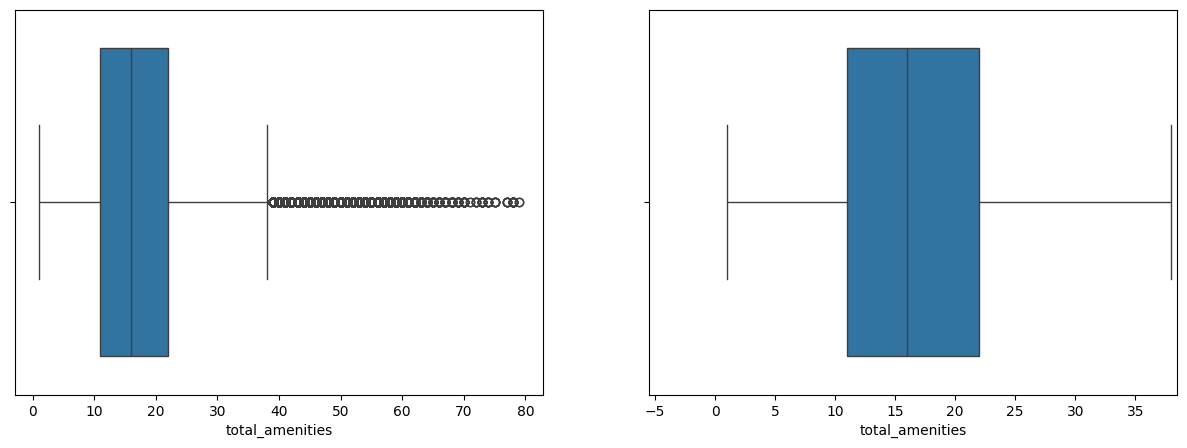

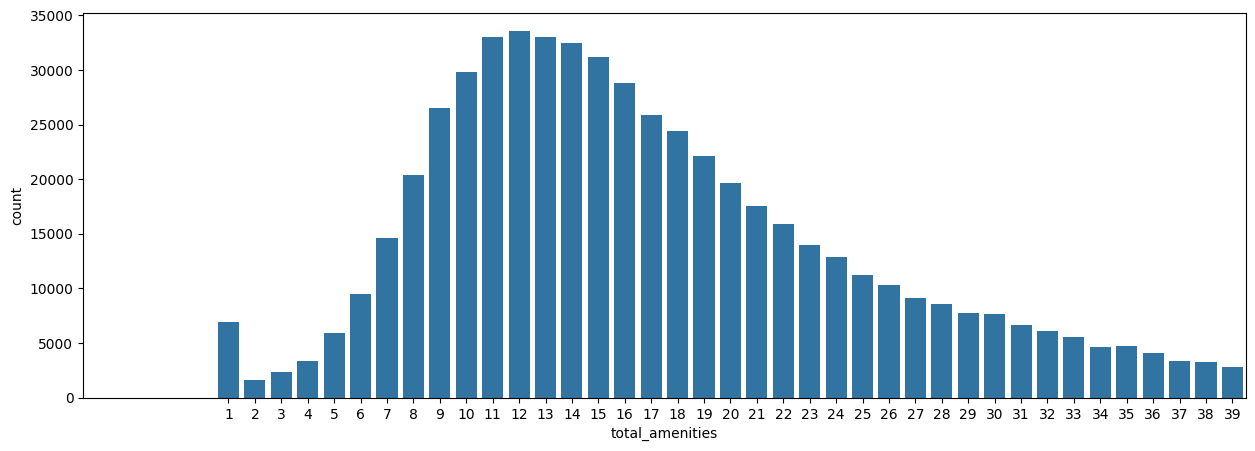

In [5]:
diagramas(base['total_amenities'])
grafico_barras(base['total_amenities'])
base, linhas_removidas = excluir_outliers(base, 'total_amenities')
print(linhas_removidas)

#### Visualização de Mapa das Propriedades

Vamos criar um mapa que exibe um pedaço da nossa base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [23]:

amostra = base.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='open-street-map')
pyo.plot(mapa, filename='mapa_airbnb.html')

'mapa_airbnb.html'

### Encoding

Precisamor Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir por 1 e 0, respectivamente.
- Features de Categoria (os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies.

In [29]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_cod = base.copy()



In [30]:
#Features de True e False
for coluna in colunas_tf:
    base_cod.loc[base_cod[coluna]=='t', coluna] = 1
    base_cod.loc[base_cod[coluna]=='f', coluna] = 0

#Features de categoria
base_cod = pd.get_dummies(data=base_cod, columns=colunas_categorias, dtype=int)

base_cod.head()

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Other Beds,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
0,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,1,0,0,0,0,1,0,0,1,0
1,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,1,0,0,0,0,1,0,0,1,0
2,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,1,0,0,0,0,1,0,0,1,0
3,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,1,0,0,0,0,1,0,0,1,0
4,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,1,0,0,0,0,1,0,0,1,0


### Modelo de Previsão

In [2]:
def avaliar_modelo(modelo, y_teste, prev):
    r2 = r2_score(y_teste, prev)
    rsme = np.sqrt(mean_squared_error(y_teste, prev))
    return  f'Modelo {modelo}:\nR²:{r2:.2%}\nRSME:{rsme:.2f}'



Escolha dos modelos a serem testados:

In [5]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = { 'LinearRegression': modelo_lr,
           'RandomForest': modelo_rf,
           'ExtraTrees': modelo_et,
          }

y = base_cod['price']
x = base_cod.drop('price', axis=1)

Separar treino e teste

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

for nome, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    prev = modelo.predict(x_test)
    print(avaliar_modelo(nome, y_test, prev))

Modelo LinearRegression:
R²:33.11%
RSME:217.37
Modelo RandomForest:
R²:97.32%
RSME:43.53
Modelo ExtraTrees:
R²:97.51%
RSME:41.98


### Análise do Melhor Modelo

- O modelo escolhido foi o ExtraTrees, apesar de apresentar resultados parecidos com o RandomForest, acaba por ser superior, apresentando uma taxa de acertos maior e menores diferenças quando erra, enfim, uma maior precisão. Em relação ao tempo de execução, ambos sao semelhantes.

Modelo ExtraTrees:
R²:97.51%, 
RSME:41.98

In [6]:
for nome, modelo in modelos.items():
    
    prev = modelo.predict(x_test)
    print(avaliar_modelo(nome, y_test, prev))

Modelo LinearRegression:
R²:33.11%
RSME:217.37
Modelo RandomForest:
R²:97.32%
RSME:43.53
Modelo ExtraTrees:
R²:97.51%
RSME:41.98


C:\Users\Acer\AppData\Local\Temp\ipykernel_27896\3347401785.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




,0
bedrooms,0.120309
latitude,0.104136
longitude,0.101931
total_amenities,0.089283
extra_people,0.087025
accommodates,0.069764
bathrooms,0.069293
minimum_nights,0.065296
room_type_Entire home/apt,0.061388
beds,0.052448


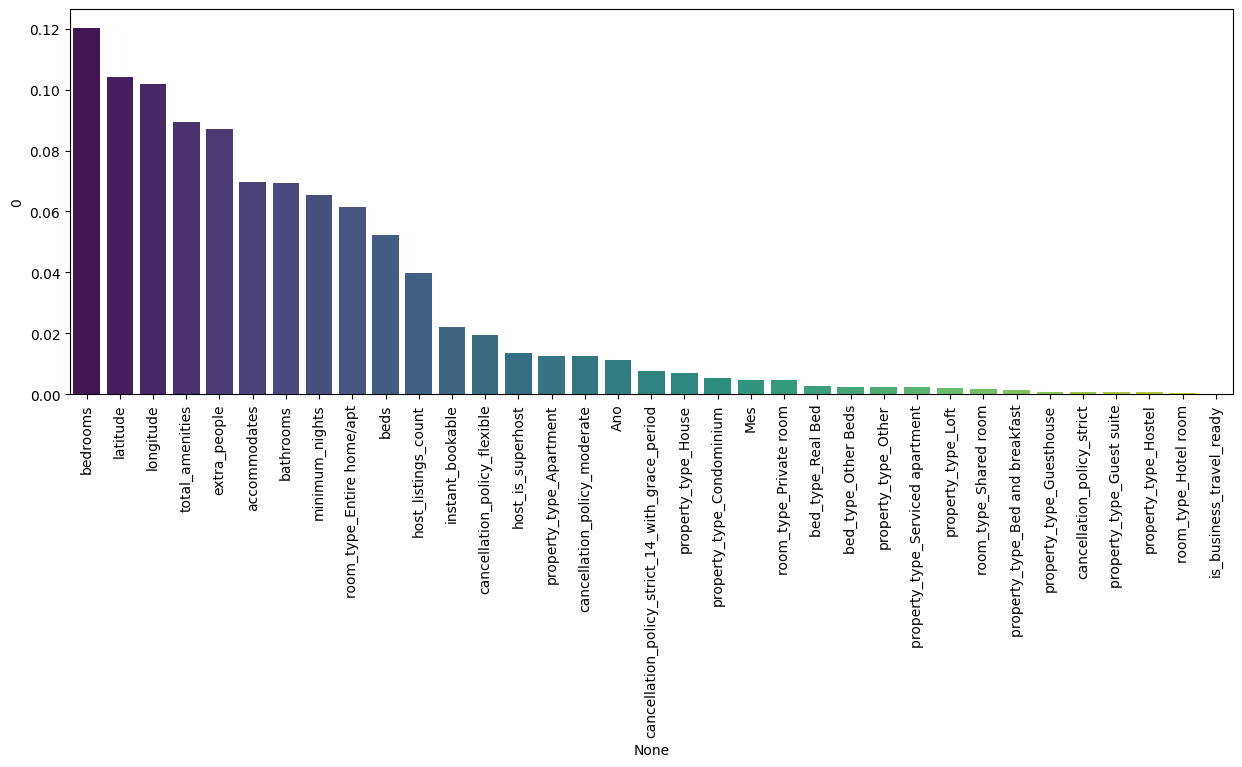

In [19]:
importancia =pd.DataFrame(modelo_et.feature_importances_, x_train.columns)
importancia = importancia.sort_values(by=0, ascending=False)

plt.figure(figsize=(15,5))
colors = sns.color_palette("viridis", len(importancia))
ax = sns.barplot(x=importancia.index, y = importancia[0], palette=colors)
ax.tick_params(axis='x', rotation=90)
display(importancia)

### Ajustes e Melhorias no Melhor Modelo

- Removendo features que não são tão relevantes e podem simplificar e melhorar nosso modelo.

In [12]:
#base_cod = base_cod.drop('is_business_travel_ready', axis=1)

y = base_cod['price']
x = base_cod.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)


modelo_et.fit(x_train, y_train)
prev = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, prev))

Modelo ExtraTrees:
R²:97.50%
RSME:41.99


- Iremos remover as colunas referentes ao bed_type, assim tornando nosso modelo mais simples e afetando pouco o seu desempenho.

In [6]:
base_test = base_cod.copy()
for coluna in base_test:
    if 'bed_type' in coluna:    
        base_test = base_test.drop(coluna, axis=1)
        
y = base_test['price']
x = base_test.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)


modelo_et.fit(x_train, y_train)
prev = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, prev))

Modelo ExtraTrees:
R²:97.51%
RSME:41.96


### Deploy

In [7]:
x['price'] = y
x.to_csv('dados.csv', index=False)

import joblib
joblib.dump(modelo_et, 'modelo.joblib')



['modelo.joblib']

In [3]:
base_cod = pd.read_csv('dados.csv')